In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import math

np.set_printoptions(precision=4)

import warnings
warnings.filterwarnings("ignore")

import networkx as nx

from connected_generation import *

# Random walk $\{S_k\}$ trajectories example

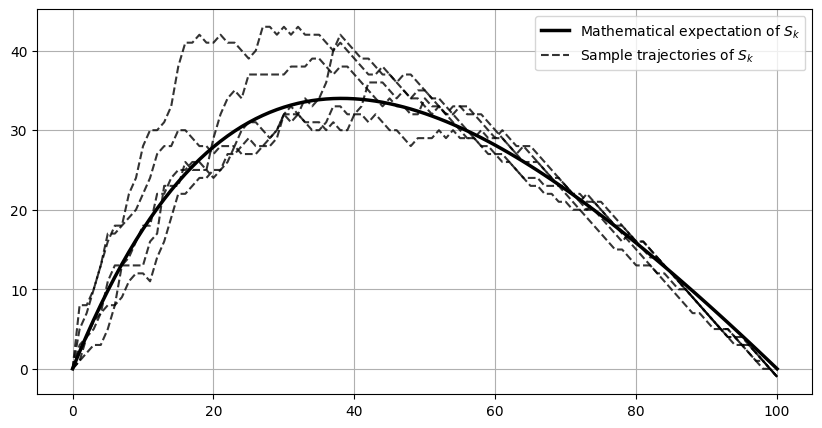

In [2]:
N = 100
p = 3/N

#Expectation
EX = np.exp(np.log(1-p)*np.arange(N))
EX = EX/sum(EX) * N
ES = np.hstack([0,np.cumsum(EX-1)])

plt.figure(figsize = (10,5))
x = np.arange(N+1)
y = ES
plt.plot(x,y, c="k", linestyle='-', linewidth = 2.5)

#Trajectories
plot_n = 5
for i in range(plot_n):
    X, S = X_S_positive_generation(N, p)

    x = np.arange(N+1)
    y = np.hstack([0, S])
    plt.plot(x,y, c="k", linestyle='--', alpha = 0.8)

plt.grid()
plt.legend(["Mathematical expectation of $S_k$", "Sample trajectories of $S_k$"])
# plt.savefig('example_eng.pdf', bbox_inches='tight')
plt.show()



# Postivity Probability 

In [3]:
N = 500
p = 2./N

# Monte-Carlo estimation
exp_n = 50000
positive_count = 0
for i in range(exp_n):
    X, S = X_S_generation(N, p)
    positive_count += (S[:-1] >= 0).all()

print('Monte-Carlo estimation: ',  positive_count / exp_n)

# Theoretical estimation
c = p * N
p_theory = (1-np.exp(-c)) * (1-c*np.exp(-c)/(1-np.exp(-c)))
print('Theoretical (asymtotic) estimation: ',  p_theory)



Monte-Carlo estimation:  0.59586
Theoretical (asymtotic) estimation:  0.5939941502901619


# $G(n,p)$ generation examples

In [4]:
# Plot
def plot_tree_graph_bw(G, ax):
    T_bfs = nx.bfs_tree(G, source=0)
    for node in T_bfs.nodes():
        T_bfs.nodes[node]['subset'] = -nx.shortest_path_length(T_bfs, source=0, target=node)
    pos_tree = nx.multipartite_layout(T_bfs, subset_key='subset', align='horizontal')
    bfs_edges = set(T_bfs.edges())
    all_edges = set(G.edges())
    back_edges = all_edges - bfs_edges
    nx.draw_networkx_nodes(G, pos_tree, ax=ax, node_size=250, node_color='white',
                           edgecolors='black', linewidths=1.2)
    nx.draw_networkx_labels(G, pos_tree, ax=ax, font_size=7)
    nx.draw_networkx_edges(G, pos_tree, ax=ax, edgelist=bfs_edges,
                           edge_color='black', style='solid', width=1.8)
    nx.draw_networkx_edges(G, pos_tree, ax=ax, edgelist=back_edges,
                           edge_color='black', style='dashed', width=1.8)
    ax.axis("off")

def plot_X(X, ax):
    x = np.arange(len(X) + 1)
    y = np.hstack([0, np.cumsum(X - 1)])
    ax.plot(x, y, color='black', linestyle='--', linewidth=2)
    ax.set_ylim((-1.5, 17))
    ax.grid(visible=True)

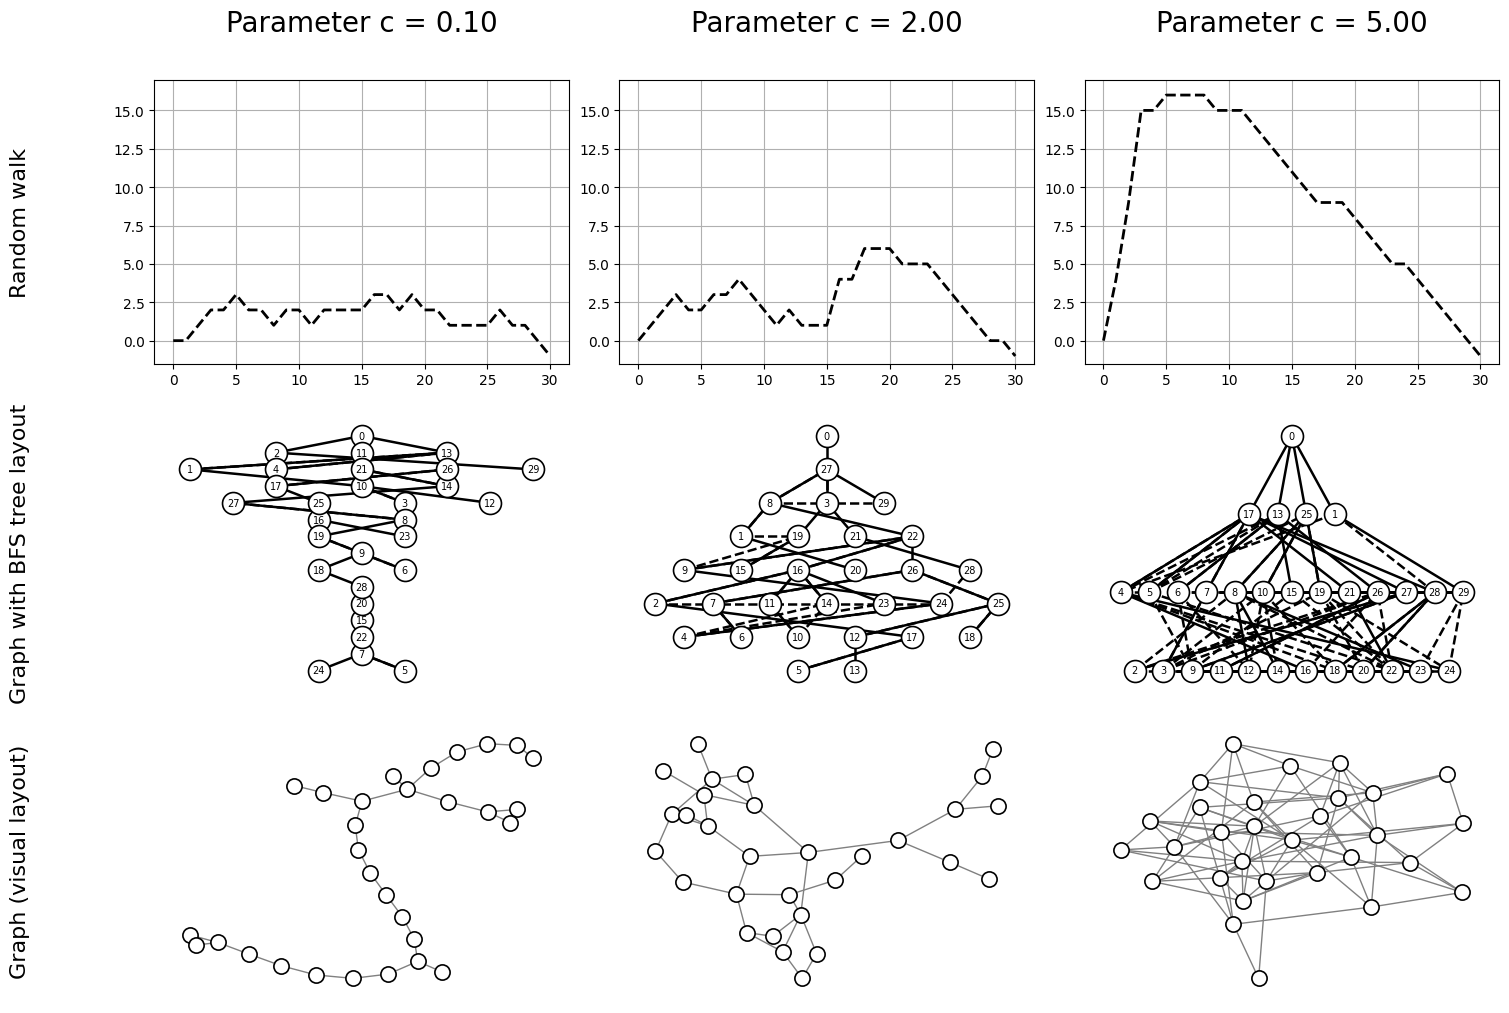

In [5]:
# seeds = [1, 2, 3]
seeds = [None, None, None]

cs = [0.1, 2.0, 5.0]
N = 30
plot_data = []
for i in range(3):
    seed = seeds[i]
    c = cs[i]
    p = c/N

    np.random.seed(seed)
    X, S = X_S_positive_generation(N, p)
    
    # G = connected_gnp_generation(N, p, seed=seed)
    G = connected_gnp_generation_fast(N, p, seed=seed)
    
    plot_data.append((X, G))


# --- Plot ---
fig, axes = plt.subplots(3, len(cs), figsize=(5 * len(cs), 10), constrained_layout=True)
row_titles = ["Random walk", "Graph with BFS tree layout", "Graph (visual layout)"]
col_titles = [f"Parameter c = {c:.2f}" for c in cs]

for row in range(3):
    axes[row, 0].text(-0.3, 0.5, row_titles[row], va='center', ha='right',
                      fontsize=16, rotation=90, transform=axes[row, 0].transAxes)
for col, (c, (X, G)) in enumerate(zip(cs, plot_data)):
    axes[0, col].text(0.5, 1.15, col_titles[col], ha='center', va='bottom',
                      fontsize=20, transform=axes[0, col].transAxes)
    plot_X(X, axes[0, col])
    plot_tree_graph_bw(G, axes[1, col])
    pos_regular = nx.spring_layout(G, seed=42)
    nx.draw(G, pos_regular, ax=axes[2, col], node_size=120, node_color='white',
            edgecolors='black', linewidths=1.2, edge_color='gray')
    axes[2, col].axis("off")
    
# plt.savefig("random_connected_graphs_bw_english.pdf", format="pdf")
plt.show()

# Empirical vertex degree distribution

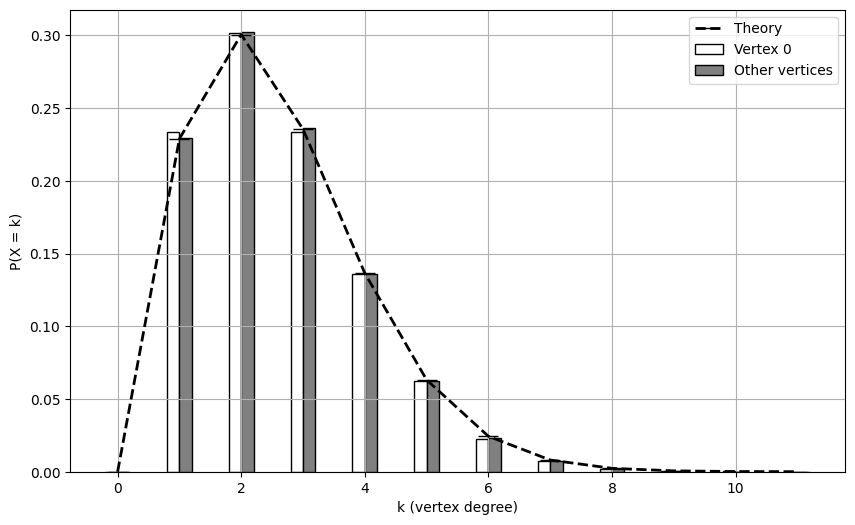

In [6]:
N = 200
c = 2.
p = c/N

# --- Emperical distribution ---
num_trials = 100000
max_k = 12

degree_counts_v0 = np.zeros(max_k)
degree_counts_others = np.zeros(max_k)

for _ in range(num_trials):
    
    # G_mc = connected_gnp_generation(N, p, seed=None)
    G_mc = connected_gnp_generation_fast(N, p, seed=None)
    degrees = np.array([deg for _, deg in G_mc.degree()])
    
    deg_v0 = degrees[0]
    if deg_v0 < max_k:
        degree_counts_v0[deg_v0] += 1
        
    for deg in degrees[1:]:
        if deg < max_k:
            degree_counts_others[deg] += 1

P_v0 = degree_counts_v0 / num_trials
P_others = degree_counts_others / (num_trials * (N - 1))


# --- Theoretical distribution---
def theoretical_distribution(c, max_k):
    gamma = c / (1 - np.exp(-c))
    values = []
    for k in range(max_k):
        poisson_part = np.exp(-gamma) * gamma**k / math.factorial(k)
        correction = (1 - np.exp(-c * k)) / (1 - np.exp(-c)) if k > 0 else 0
        values.append(poisson_part * correction)
    return np.array(values)

def theoretical_distribution2(c, max_k):
    values = []
    for k in range(max_k):
        poisson_part = np.exp(-c) * c**k / math.factorial(k)
        correction = 1
        values.append(poisson_part * correction)
    return np.array(values)

P_theoretical = theoretical_distribution(c, max_k)
P_poiss = theoretical_distribution2(c, max_k)


# --- Plot ---
x = np.arange(max_k)
plt.figure(figsize=(10, 6))
plt.bar(x - 0.1, P_v0, width=0.2, color="white", edgecolor="black", label="Vertex 0")
plt.bar(x + 0.1, P_others, width=0.2, color="gray", edgecolor="black", label="Other vertices")
plt.plot(x, P_theoretical, "--", color="black", linewidth=2, label="Theory", marker = "_", markersize = 15)
# plt.plot(x, P_poiss, "-*", color="black", linewidth=2, label="Poiss")

plt.xlabel("k (vertex degree)")
plt.ylabel("P(X = k)")
plt.legend()
plt.grid(True)
# plt.savefig("degree_distribution_comparison_bw_eng.pdf", format="pdf")
plt.show()

# Average degree from c


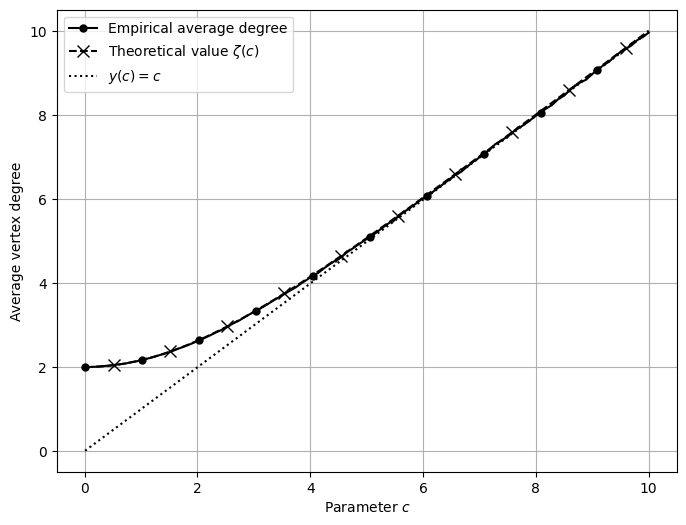

In [7]:
N = 300
c_values = np.linspace(0.01, 10, 100)
num_trials = 200
average_degrees_over_c = []


# --- Emperical values ---
for c in c_values:
    total_degree = 0
    for _ in range(num_trials):
        G_mc = connected_gnp_generation_fast(N, c/N, seed=None)
        degrees = np.array([degree for _, degree in G_mc.degree()])
        total_degree += np.mean(degrees)
    
    average_degree = total_degree / num_trials
    average_degrees_over_c.append(average_degree)

average_degrees_over_c = np.array(average_degrees_over_c)


# --- Theoretical values ---
def theoretical_mu(c):
    return c * (1 + np.exp(-c)) / (1 - np.exp(-c))

theoretical_values = theoretical_mu(c_values)
linear_values = c_values * (N-1)/N # f(c) = c


# --- Plot ---
marker_even = range(0, len(c_values), 10)
marker_odd = range(5, len(c_values), 10)
line_styles = {
    "empirical": {
        "linestyle": "-", "color": "black", "linewidth": 1.5,
        "marker": "o", "markevery": marker_even, "markersize": 5
    },
    "theoretical": {"linestyle": "--", "color": "black", "linewidth": 1.5, "marker": "x", "markevery": marker_odd, "markersize": 8},
    "linear": {"linestyle": ":", "color": "black", "linewidth": 1.5},
}
plt.figure(figsize=(8, 6))
plt.plot(c_values, average_degrees_over_c, label="Empirical average degree", **line_styles["empirical"])
plt.plot(c_values, theoretical_values, label="Theoretical value $\zeta(c)$", **line_styles["theoretical"])
plt.plot(c_values, linear_values, label=r"$y(c) = c$", **line_styles["linear"])
plt.xlabel("Parameter $c$")
plt.ylabel("Average vertex degree")
# plt.title("Average vertex degree vs parameter $c$")
plt.legend()
plt.grid(True)
# plt.savefig("degree2_bw_english.pdf", format="pdf")
plt.show()

# $G(n,M)$ via $G(n,p)$


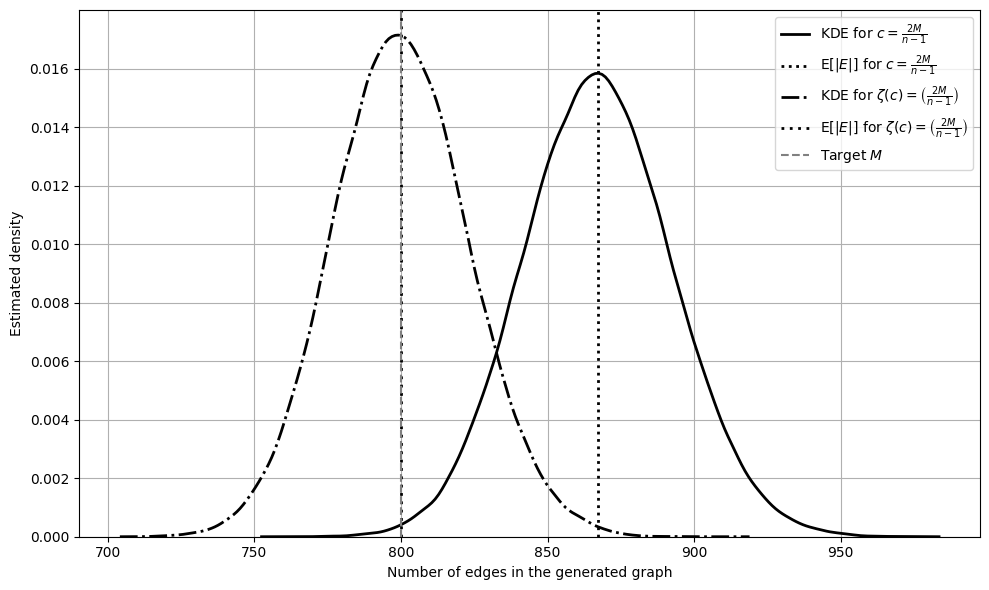

In [8]:
def generate_samples(N, p, samples=10000):
    stats = []
    for _ in range(samples):
        X, S = X_S_positive_generation(N, p)
        random_edges_num = np.sum(S[:-1])
        edges_num = N - 1 + np.random.binomial(random_edges_num, p)
        stats.append(edges_num)

    return stats

# === Parameters ===
N = 500
M_target = 800
samples = 100000

# Naive method
c1 = 2 * M_target / (N - 1)
p1 = c1 / N
stats_naive = generate_samples(N, p1, samples)
mean_naive = np.mean(stats_naive)

# Corrected method
# c2 = invert_f(2 * M_target / (N))
c2 = invert_f(2 * M_target / (N - 1))
p2 = c2 / N
stats_corrected = generate_samples(N, p2, samples)
mean_corrected = np.mean(stats_corrected)

# === Plot ===
# plt.rcParams.update({"text.usetex": False})  # Use plain mathtext

plt.figure(figsize=(10, 6))

# Naive KDE
sns.kdeplot(stats_naive, color='black', linestyle='solid', linewidth=2,
            label=r"KDE for $c = \frac{2M}{n-1}$")
plt.axvline(mean_naive, color='black', linestyle='dotted', linewidth=2,
            label=r"$\mathrm{E}[|E|]$ for $c = \frac{2M}{n-1}$")

# Corrected KDE
sns.kdeplot(stats_corrected, color='black', linestyle='dashdot', linewidth=2,
            label=r"KDE for $\zeta(c) = \left(\frac{2M}{n-1}\right)$")
plt.axvline(mean_corrected, color='black', linestyle=(0, (1, 2)), linewidth=2,
            label=r"$\mathrm{E}[|E|]$ for $\zeta(c) = \left(\frac{2M}{n-1}\right)$")

# Target line
plt.axvline(M_target, color='gray', linestyle='--', linewidth=1.5,
            label=r"Target $M$")

# Labels and style
plt.xlabel("Number of edges in the generated graph")
plt.ylabel("Estimated density")
# plt.title(r"Distribution of the number of edges when generating $G(n,m)$ via $G(n,p)$")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save to PDF
# plt.savefig("edges_distribution_Gnm.pdf")
plt.show()

# $G(n,M)$ generation examples

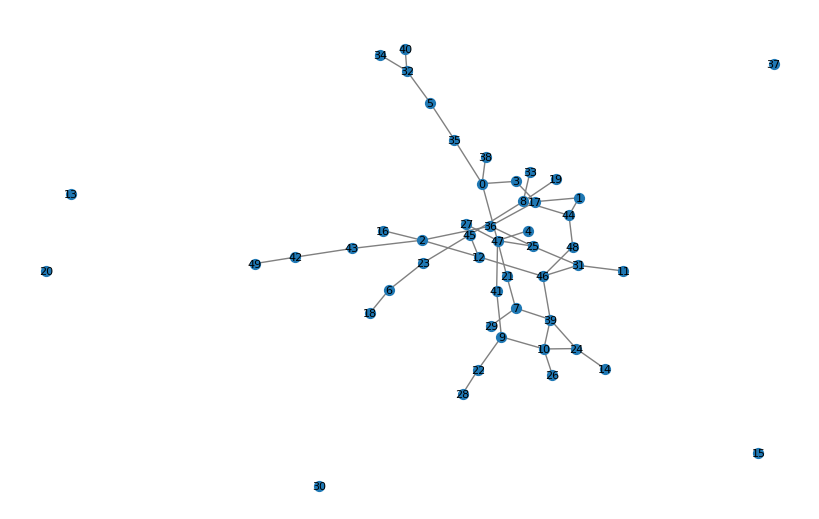

Number of edges:  52


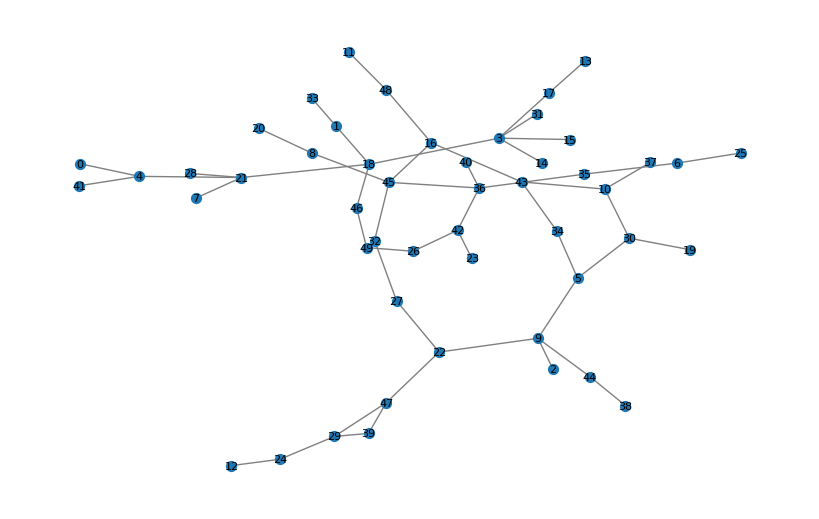

Number of edges:  52


In [9]:

N = 50
M = 52

G = nx.gnm_random_graph(N, M, directed=False)
visualize_G(G)
print("Number of edges: ", G.number_of_edges())

G = connected_gnm_generation_fast(N, M)
visualize_G(G)
print("Number of edges: ", G.number_of_edges())


# Time comparison

In [10]:
import time

########################################
N = 10000
c = 3.
p = c/N
M = int(p * N *(N-1)/2)

print("Time for N = {N}, p = {c:.1g}/N, M = p * N *(N-1)/2 = {M}".format(N=N, c=c, M=M))


t0 = time.time()
G = nx.gnp_random_graph(N, p)
t1 = time.time()
print("nx.gnp_random_graph(N, p): ", t1-t0)

t0 = time.time()
G = nx.fast_gnp_random_graph(N, p)
t1 = time.time()
print("nx.fast_gnp_random_graph(N, p): ", t1-t0)

t0 = time.time()
G = connected_gnp_generation(N,p)
t1 = time.time()
print("connected_gnp_generation(N,p): ", t1-t0)

t0 = time.time()
G = connected_gnp_generation_fast(N,p)
t1 = time.time()
print("connected_gnp_generation_fast(N,p): ", t1-t0)

t0 = time.time()
G = connected_gnm_generation_fast(N, M = int(p * N *(N-1)/2))
t1 = time.time()
print("connected_gnm_generation_fast(N, M): ", t1-t0)

########################################

N = 1000000
p = 3/N

print()
print("Time for N = {N}, p = {c:.1g}/N".format(N=N, c=c, M=M))

t0 = time.time()
G = nx.fast_gnp_random_graph(N, p)
t1 = time.time()
print("nx.fast_gnp_random_graph(N, p): ", t1-t0)

t0 = time.time()
G = connected_gnp_generation_fast(N,p)
t1 = time.time()
print("connected_gnp_generation_fast(N,p): ", t1-t0)



Time for N = 10000, p = 3/N, M = p * N *(N-1)/2 = 14998
nx.gnp_random_graph(N, p):  2.313416004180908
nx.fast_gnp_random_graph(N, p):  0.014429807662963867
connected_gnp_generation(N,p):  5.319764852523804
connected_gnp_generation_fast(N,p):  0.029855966567993164
connected_gnm_generation_fast(N, M):  0.07230091094970703

Time for N = 1000000, p = 3/N
nx.fast_gnp_random_graph(N, p):  3.2184371948242188
connected_gnp_generation_fast(N,p):  6.097932815551758
